## Car insurance claim prediction


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests

##import ML libraries for training, testing and evaluating Xgboost model
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
import xgboost as xgb

from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTENC


C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Import data

44 columns with varying data types. 

Data requires significant cleaning; for example max_power stored as string "40.36bhp@6000rpm"


In [2]:
data = pd.read_csv('data/train.csv')
data.head(10)

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0
5,ID00006,1.018709,0.07,0.519231,C6,13051,3,C2,M4,Diesel,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
6,ID00007,0.097992,0.16,0.403846,C7,6112,4,B2,M5,Diesel,...,No,Yes,Yes,Yes,No,No,Yes,Yes,5,0
7,ID00008,0.509085,0.14,0.423077,C8,8794,1,B2,M6,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
8,ID00009,0.282394,0.07,0.298077,C7,6112,3,C2,M4,Diesel,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
9,ID00010,0.566255,0.04,0.442308,C9,17804,1,B2,M7,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0,0


## How balanced is the data? What is the distribution of the target variable?

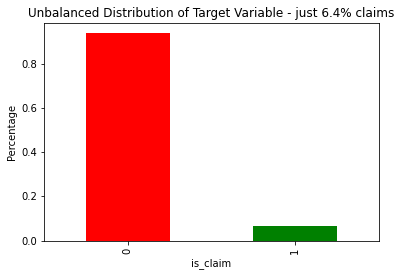

In [3]:
target = data['is_claim']
##plot the distribution of the target variable as percentage with value labels
target_counts = target.value_counts(normalize=True)
perc_claims = target_counts[1]*100

target_counts.plot(kind='bar', 
                   title=f"Unbalanced Distribution of Target Variable - just {perc_claims:.1f}% claims", color=['red', 'green'])
plt.xlabel('is_claim')
plt.ylabel('Percentage')
plt.show()



In [4]:
##function to change binary categorical variables to 1/0. Input may not be yes/no but any binary categorical variable
def yes_no_to_1_0(x):
    if x == 'Yes':
        return 1
    elif x == 'No':
        return 0
    else:
        return x
    


##find all columns with yes/no values, 2 unique values and contains the string "Yes"
yes_no_cols = [col for col in data.columns if data[col].nunique() == 2 and data[col].dtype == 'object' and 'Yes' in data[col].unique()]

##apply the function to the dataframe
data[yes_no_cols] = data[yes_no_cols].applymap(yes_no_to_1_0)
##covert yes/no columns to categorical variables
data[yes_no_cols] = data[yes_no_cols].astype('category')

##view the first 10 rows of the dataframe
data[yes_no_cols].head(10)


,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert
0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
3,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1
4,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1
6,0,1,0,1,0,0,0,0,0,0,1,1,1,0,0,1,1
7,0,1,0,1,0,1,0,0,0,1,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1
9,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [5]:
##extract number from max_power column (e.g. 40.36bhp@6000rpm to 40.36)
data['max_power'] = data['max_power'].str.extract('(\d+\.\d+)').astype(float)

##extract number from max_torque column (e.g. 200Nm@1750-2750rpm to 200)
data['max_torque'] = data['max_torque'].str.extract('(\d+)').astype(float)

data.info

<bound method DataFrame.info of       policy_id  policy_tenure  age_of_car  age_of_policyholder area_cluster  \
0       ID00001       0.515874        0.05             0.644231           C1   
1       ID00002       0.672619        0.02             0.375000           C2   
2       ID00003       0.841110        0.02             0.384615           C3   
3       ID00004       0.900277        0.11             0.432692           C4   
4       ID00005       0.596403        0.11             0.634615           C5   
...         ...            ...         ...                  ...          ...   
58587   ID58588       0.355089        0.13             0.644231           C8   
58588   ID58589       1.199642        0.02             0.519231          C14   
58589   ID58590       1.162273        0.05             0.451923           C5   
58590   ID58591       1.236307        0.14             0.557692           C8   
58591   ID58592       0.124429        0.02             0.442308           C8   

       

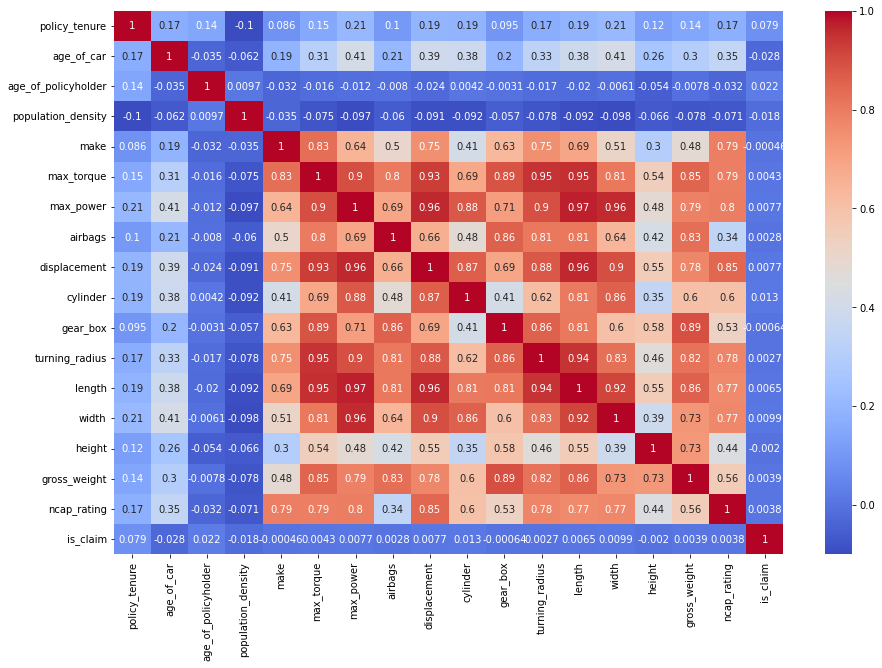

In [6]:
## identify numerical columns
num_cols = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]
##plot correlation matrix
corr = data[num_cols].corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()




In [7]:
##scale the numerical columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data[num_cols]), columns=num_cols)

scaled_data['is_claim'] = target

num_cols_not_target = [col for col in num_cols if col != 'is_claim']

In [8]:
from sklearn.linear_model import LogisticRegression
ridge_reg = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs')
ridge_reg.fit(scaled_data[num_cols_not_target], target)


lasso_reg = LogisticRegression(penalty='l1', C=1.0, solver='saga')
lasso_reg.fit(scaled_data[num_cols_not_target], target)

##add both sets of coefficients to a dataframe
coef_df = pd.DataFrame({ 'ridge_coef': ridge_reg.coef_[0], 'lasso_coef': lasso_reg.coef_[0]}, index=num_cols_not_target)
##arrange by absolute ridge + lasso coefficient value
coef_df = coef_df.reindex(coef_df.abs().sum(axis=1).sort_values(ascending=False).index)
coef_df

,ridge_coef,lasso_coef
policy_tenure,0.347945,0.347507
max_power,-0.193092,-0.229100
length,0.242219,0.177690
age_of_car,-0.203823,-0.203824
turning_radius,-0.124731,-0.070976
cylinder,0.053952,0.112273
height,-0.085836,-0.061792
gross_weight,0.072084,0.054129
ncap_rating,0.057687,0.059249
population_density,-0.051348,-0.051007


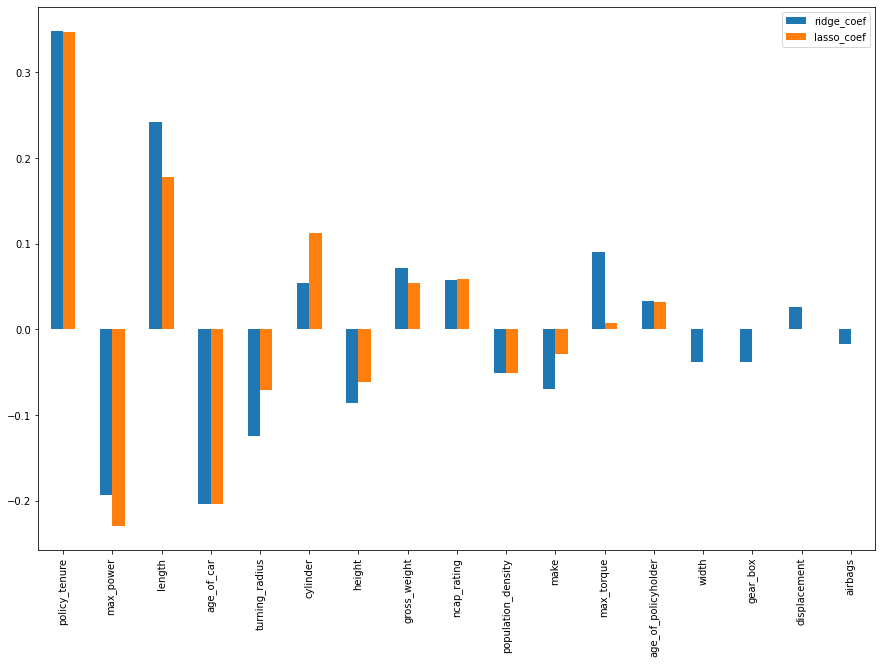

In [9]:
##plot the coefficients
coef_df.plot(kind='bar', figsize=(15,10))
plt.show()

In [10]:
##make a list of columns to drop (meam absolute coefficient value < 0.06)
min_abs_coeff = 0.05
cols_to_drop = coef_df[abs(coef_df).mean(axis=1) < min_abs_coeff].index.tolist()
cols_to_drop


['make',
 'max_torque',
 'age_of_policyholder',
 'width',
 'gear_box',
 'displacement',
 'airbags']

## Plot Binomial Regression 

In [11]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

def plot_binomial_regression(x, y=data['is_claim'], title='', xlabel='', ylabel='Claim Probability', figsize=(10, 4.5)):
    """
    Plot a binomial regression using statsmodels GLM.

    Args:
        x (numpy array or pandas DataFrame): The predictor variable.
        y (numpy array or pandas Series): The response variable.
        title (str): The plot title. Default is ''.
        xlabel (str): The label for the x-axis. Default is ''.
        ylabel (str): The label for the y-axis. Default is ''.
        figsize (tuple): The size of the plot in inches. Default is (10, 6).

    Returns:
        None
    """
    # Fit the binomial GLM model
    binomial_reg = sm.GLM(y, sm.add_constant(x), family=sm.families.Binomial()).fit()

    # Generate predicted values for plotting the line
    x_pred = np.linspace(x.min(), x.max(), 100)
    y_pred = binomial_reg.predict(sm.add_constant(x_pred))

    # Plot the data points and the regression line
    fig, ax = plt.subplots(figsize=figsize)
    #ax.scatter(x, y, color='b', alpha=0.5, label='Data')
    ax.plot(x_pred, y_pred, color='r', label='Regression Line')

    # Add plot labels and legend
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

    plt.show()


C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


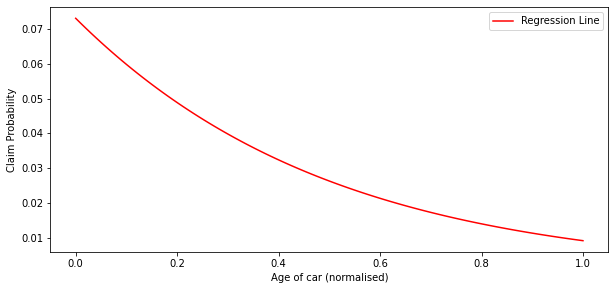

In [12]:
plot_binomial_regression(x=data['age_of_car'],xlabel='Age of car (normalised)')


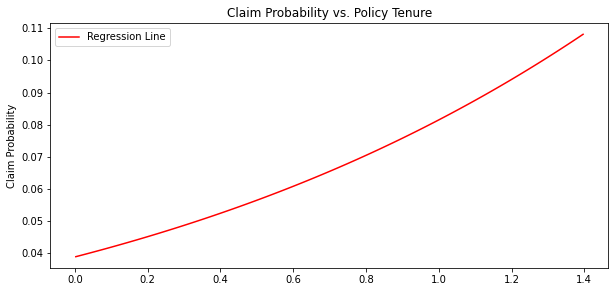

In [13]:
plot_binomial_regression(data['policy_tenure'], title='Claim Probability vs. Policy Tenure')

In [14]:
## identify all categorical variables
cat_cols = [col for col in data.columns if data[col].dtype == 'object']
cat_cols

['policy_id',
 'area_cluster',
 'segment',
 'model',
 'fuel_type',
 'engine_type',
 'rear_brakes_type',
 'transmission_type',
 'steering_type']

In [15]:
##count na values in each column
na_counts = data.isna().sum()
##sort the counts in descending order
na_counts.sort_values(ascending=False, inplace=True)
##show columns with at least 1 na value
na_counts[na_counts > 0]

Series([], dtype: int64)

In [16]:
##perform a chi-squared test to see if there is a relationship between the target variable and the yes_no_cols
from scipy.stats import chi2_contingency

##create a list of p-values
p_values = []

##loop through each column cat_cols and yes_no_cols and perform chi-squared test
for col in cat_cols + yes_no_cols:
    ##create a contingency table
    contingency_table = pd.crosstab(data[col], data['is_claim'])
    ##perform a chi-squared test
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    ##append the p-value to the list
    p_values.append(p)
    ##print the results inclusing column name
    print(f"Chi2 for {col}: {chi2:.2f}, p-value: {p:.4f}, n degrees of freedom: {dof}")


Chi2 for policy_id: 58592.00, p-value: 0.4981, n degrees of freedom: 58591
Chi2 for area_cluster: 96.08, p-value: 0.0000, n degrees of freedom: 21
Chi2 for segment: 12.60, p-value: 0.0274, n degrees of freedom: 5
Chi2 for model: 19.97, p-value: 0.0295, n degrees of freedom: 10
Chi2 for fuel_type: 5.76, p-value: 0.0561, n degrees of freedom: 2
Chi2 for engine_type: 19.97, p-value: 0.0295, n degrees of freedom: 10
Chi2 for rear_brakes_type: 0.02, p-value: 0.8805, n degrees of freedom: 1
Chi2 for transmission_type: 0.02, p-value: 0.8914, n degrees of freedom: 1
Chi2 for steering_type: 5.74, p-value: 0.0568, n degrees of freedom: 2
Chi2 for is_esc: 0.50, p-value: 0.4797, n degrees of freedom: 1
Chi2 for is_adjustable_steering: 11.23, p-value: 0.0008, n degrees of freedom: 1
Chi2 for is_tpms: 0.02, p-value: 0.8805, n degrees of freedom: 1
Chi2 for is_parking_sensors: 3.98, p-value: 0.0460, n degrees of freedom: 1
Chi2 for is_parking_camera: 0.04, p-value: 0.8465, n degrees of freedom: 1
Chi

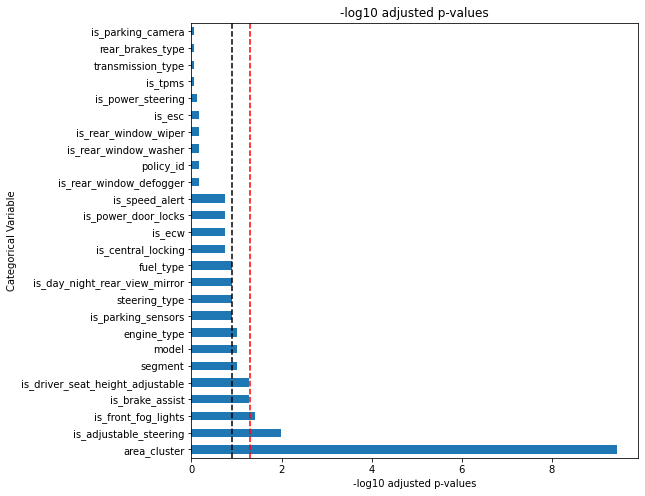

In [17]:
##create a dataframe with the p-values
p_values_df = pd.DataFrame({'p_values': p_values}, index=cat_cols + yes_no_cols)
##adjust the p-values for multiple testing
p_values_df['p_values_adj'] = multipletests(p_values_df['p_values'], method='fdr_bh')[1]
##add minus log10 adjusted p-value
p_values_df['-log10(p_values_adj)'] = -np.log10(p_values_df['p_values_adj'])
##sort the values in descending order
p_values_df.sort_values(by='-log10(p_values_adj)', ascending=False, inplace=True)


#incrwease the size of the plot
plt.rcParams['figure.figsize'] = [8, 8]
##plot the -log10 adj p-values  
p_values_df['-log10(p_values_adj)'].plot(kind='barh', title='-log10 adjusted p-values')
plt.ylabel('Categorical Variable')
plt.xlabel('-log10 adjusted p-values')
##add vertical line at -log10 0.05
plt.axvline(x=-np.log10(0.125), color='black', linestyle='--')
plt.axvline(x=-np.log10(0.05), color='red', linestyle='--')
plt.show()

## Drop columns with adjusted p-value greater than 0.15

In [18]:
##append the columns to drop to the list of columns to drop
cols_to_drop += p_values_df[p_values_df['p_values_adj'] > 0.175].index.tolist()
cols_to_drop


['make',
 'max_torque',
 'age_of_policyholder',
 'width',
 'gear_box',
 'displacement',
 'airbags',
 'is_central_locking',
 'is_ecw',
 'is_power_door_locks',
 'is_speed_alert',
 'is_rear_window_defogger',
 'policy_id',
 'is_rear_window_washer',
 'is_rear_window_wiper',
 'is_esc',
 'is_power_steering',
 'is_tpms',
 'transmission_type',
 'rear_brakes_type',
 'is_parking_camera']

In [19]:
data2 = data.drop(columns=cols_to_drop)
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   policy_tenure                     58592 non-null  float64 
 1   age_of_car                        58592 non-null  float64 
 2   area_cluster                      58592 non-null  object  
 3   population_density                58592 non-null  int64   
 4   segment                           58592 non-null  object  
 5   model                             58592 non-null  object  
 6   fuel_type                         58592 non-null  object  
 7   max_power                         58592 non-null  float64 
 8   engine_type                       58592 non-null  object  
 9   is_adjustable_steering            58592 non-null  category
 10  is_parking_sensors                58592 non-null  category
 11  cylinder                          58592 non-null  int6

In [20]:
##create a list of columns to creare dummy variables - object or category
dummy_cols = [col for col in data2.columns if data2[col].dtype in ['object', 'category']]

##create dummy variables
data2 = pd.get_dummies(data2, columns=dummy_cols, drop_first=True)




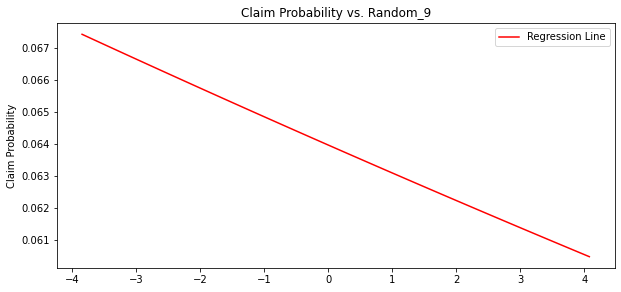

In [21]:
## add 10 random normally distributed column to the data in order to assess feature importance
for i in range(10):
    ##create a random normally distributed column
    data2[f'random_{i}'] = np.random.normal(size=data2.shape[0])

    ##create a binomial regression plot
plot_binomial_regression(data2[f'random_{i}'], title=f'Claim Probability vs. Random_{i}')

In [22]:
##create a list of columns to scale random columns and num_cols 
scale_cols = [col for col in data2.columns if col.startswith('random') or col in num_cols]
##do not scale target variable ('is_claim')
scale_cols.remove('is_claim')

##create a scaler object
scaler = StandardScaler()
##fit the scaler to the data
scaler.fit(data2[scale_cols])
##transform the data
data2[scale_cols] = scaler.transform(data2[scale_cols])

data2.head()

,policy_tenure,age_of_car,population_density,max_power,cylinder,turning_radius,length,height,gross_weight,ncap_rating,...,random_0,random_1,random_2,random_3,random_4,random_5,random_6,random_7,random_8,random_9
0,-0.230283,-0.342447,-0.783513,-1.394156,-1.296417,-1.108893,-1.301882,-0.983846,-0.942828,-1.266548,...,-1.310288,1.150443,1.313345,-1.238053,0.127906,0.216802,-1.693206,-0.104087,0.151162,0.823045
1,0.148188,-0.871359,0.462975,-1.394156,-1.296417,-1.108893,-1.301882,-0.983846,-0.942828,-1.266548,...,0.002206,-0.759746,-0.327416,-1.245744,-0.115797,0.549233,-0.143869,0.026680,-0.963169,1.315539
2,0.555022,-0.871359,-0.835268,-1.394156,-1.296417,-1.108893,-1.301882,-0.983846,-0.942828,-1.266548,...,-1.266126,-0.132642,-0.496637,0.757671,0.713448,-0.453902,-0.862408,-1.192717,0.062670,-0.266590
3,0.697883,0.715378,0.158275,0.343811,0.771357,-0.231926,0.464026,-0.481470,-0.236684,0.172752,...,0.825857,0.107122,2.244911,0.583952,-0.667305,0.264423,-1.109807,1.002918,-0.818370,0.591447
4,-0.035840,0.715378,0.900969,-0.430223,-1.296417,0.645040,-0.383610,-0.795455,-1.084057,0.172752,...,-1.806509,1.431715,1.753088,-2.378336,0.567250,-1.234303,-0.578579,-0.532857,1.955436,1.790037


In [38]:
##create x and y variables
X = data2.drop(columns='is_claim')
y = data2['is_claim']

##split the data into train and test sets
##all suffix to show these are not feature selected
X_train_all, X_test_all, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

##count the value and percentage of 1s and 0s in the train and test sets
for df in [y_train, y_test]:
    print(df.value_counts(normalize=True))
    print()

0    0.936022
1    0.063978
Name: is_claim, dtype: float64

0    0.936056
1    0.063944
Name: is_claim, dtype: float64



In [24]:
##calculate ratio of 1s to 0s in the train set
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
ratio

14.630335365853659

In [25]:
##fit the model to the training data
##create an xgb classifier object with 750 trees
##unbalanced dataset so use scale_pos_weight to balance the classes


xgb_clf = xgb.XGBClassifier(n_estimators=500, 
                            scale_pos_weight=ratio*2, 
                            random_state=42, 
                            n_jobs=-1,
                            objective='binary:logistic', 
                            eval_metric='logloss')


xgb_clf.fit(X_train_all, y_train)

C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=29.260670731707318,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [26]:
##test model performance on the test set
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score

##make predictions on the test set
y_pred = xgb_clf.predict(X_test_all)

##print the accuracy, precision and recall
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")

##confusion matrix
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")



Accuracy: 0.898
Precision: 0.095
Recall: 0.070
Confusion Matrix:
[[15701   753]
 [ 1045    79]]


In [27]:
##repeat over a range of thresholds
y_pred_proba = xgb_clf.predict_proba(X_test_all)

# print recall and accuracy at different thresholds
for threshold in np.arange(0.1, 1, 0.1):
    y_pred = np.where(y_pred_proba[:, 1] > threshold, 1, 0)
    print(f"------------Threshold: {threshold:.1f}------------")
    print(f"Recall: {recall_score(y_test, y_pred):.3f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    ##confusion matrix
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")


------------Threshold: 0.1------------
Recall: 0.410
Accuracy: 0.674
Confusion Matrix:
[[11384  5070]
 [  663   461]]
------------Threshold: 0.2------------
Recall: 0.247
Accuracy: 0.779
Confusion Matrix:
[[13422  3032]
 [  846   278]]
------------Threshold: 0.3------------
Recall: 0.164
Accuracy: 0.837
Confusion Matrix:
[[14520  1934]
 [  940   184]]
------------Threshold: 0.4------------
Recall: 0.104
Accuracy: 0.873
Confusion Matrix:
[[15235  1219]
 [ 1007   117]]
------------Threshold: 0.5------------
Recall: 0.070
Accuracy: 0.898
Confusion Matrix:
[[15701   753]
 [ 1045    79]]
------------Threshold: 0.6------------
Recall: 0.040
Accuracy: 0.915
Confusion Matrix:
[[16035   419]
 [ 1079    45]]
------------Threshold: 0.7------------
Recall: 0.018
Accuracy: 0.925
Confusion Matrix:
[[16247   207]
 [ 1104    20]]
------------Threshold: 0.8------------
Recall: 0.007
Accuracy: 0.932
Confusion Matrix:
[[16373    81]
 [ 1116     8]]
------------Threshold: 0.9------------
Recall: 0.000
Acc

C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


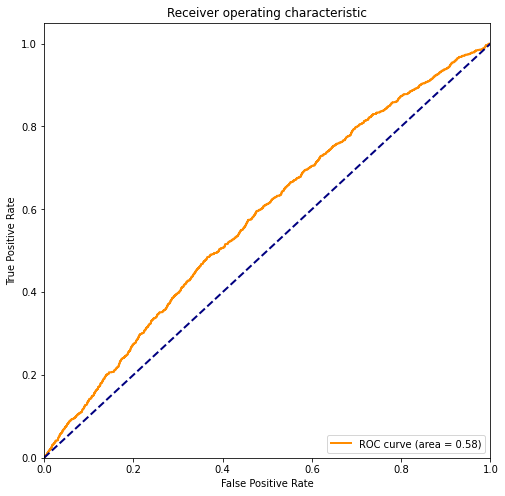

In [28]:
##create a datframe of y_pred_proba with y_test
y_pred_proba_df = pd.DataFrame(y_pred_proba, columns=['prob_0', 'prob_1'])
y_pred_proba_df['y_test'] = y_test.values


##plot ROC curve
from sklearn.metrics import roc_curve, auc

##calculate false positive rate, true positive rate and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

##calculate the area under the curve
roc_auc = auc(fpr, tpr)

##plot the ROC curve

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

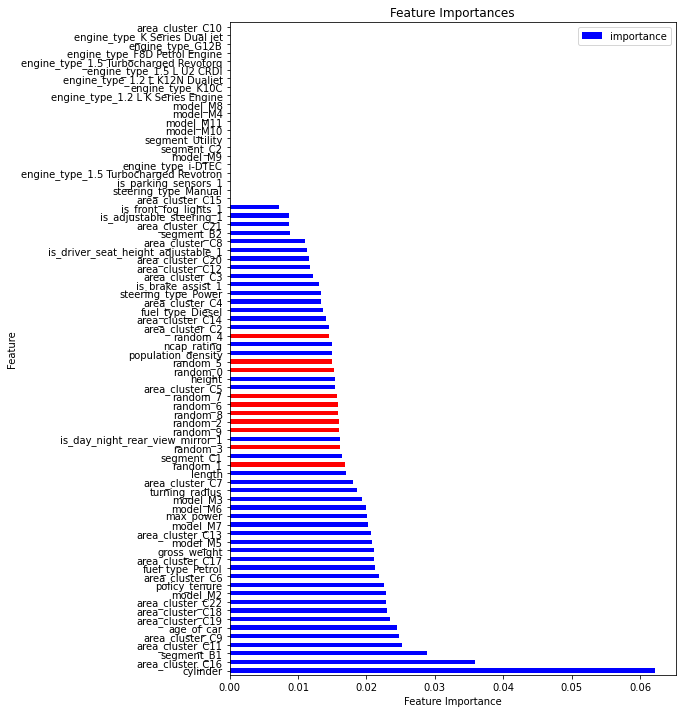

In [29]:
##get fesatures importances
feature_importances = xgb_clf.feature_importances_
##create a dataframe with the feature importances
feature_importances_df = pd.DataFrame({'feature': X_train_all.columns, 'importance': feature_importances})
##sort the values in descending order
feature_importances_df.sort_values(by='importance', ascending=False, inplace=True)
##determine if feature is random
feature_importances_df['is_random'] = feature_importances_df['feature'].str.contains('random')
##plot the feature importances, with random features in red
feature_importances_df.plot(kind='barh', x='feature', y='importance', color=feature_importances_df['is_random'].map({True: 'red', False: 'blue'}), figsize=(8, 12))
plt.title('Feature Importances')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

In [30]:
##get the third highest random feature importance
second_highest_random_importance = feature_importances_df[feature_importances_df['is_random'] == True]['importance'].iloc[2]
##get the features with importance greater than the second highest random feature importance
features_to_keep = feature_importances_df[feature_importances_df['importance'] > second_highest_random_importance]['feature'].tolist()
##remove the random features
features_to_keep = [col for col in features_to_keep if not col.startswith('random')]
##print the features to keep
features_to_keep

['cylinder',
 'area_cluster_C16',
 'segment_B1',
 'area_cluster_C11',
 'area_cluster_C9',
 'age_of_car',
 'area_cluster_C19',
 'area_cluster_C18',
 'area_cluster_C22',
 'model_M2',
 'policy_tenure',
 'area_cluster_C6',
 'fuel_type_Petrol',
 'area_cluster_C17',
 'gross_weight',
 'model_M5',
 'area_cluster_C13',
 'model_M7',
 'max_power',
 'model_M6',
 'model_M3',
 'turning_radius',
 'area_cluster_C7',
 'length',
 'segment_C1',
 'is_day_night_rear_view_mirror_1']

## Re-train with only features that outperformed at least 3 random variables

In [39]:
##retrain model with only the features to keep
##create x and y variables
from sklearn.metrics import classification_report


X = data2[features_to_keep]
y = data2['is_claim']

##subset X_train and X_test to only include the features to keep
X_train = X_train_all[features_to_keep]
X_test = X_test_all[features_to_keep]

##calculate ratio of 1s to 0s in the train set
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Ratio of 0s to 1s in the train set: {ratio:.2f}")

##create classifier object
xgb_clf2 = xgb.XGBClassifier(n_estimators=500,
                            scale_pos_weight=ratio*2,
                            random_state=42,
                            n_jobs=-1,
                            objective='binary:logistic',
                            eval_metric='logloss')

##fit the model to the training data
xgb_clf2.fit(X_train, y_train)

##make predictions on the test set
y_pred = xgb_clf2.predict(X_test)

##printclassification report
print(classification_report(y_test, y_pred))


##confusion matrix
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

Ratio of 0s to 1s in the train set: 14.63


C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


              precision    recall  f1-score   support

           0       0.95      0.75      0.84     16454
           1       0.09      0.37      0.15      1124

    accuracy                           0.73     17578
   macro avg       0.52      0.56      0.49     17578
weighted avg       0.89      0.73      0.79     17578

Confusion Matrix:
[[12363  4091]
 [  706   418]]


## Repeat again with re-sampling to syntheise fake data in order to balance 0's and 1's

In [32]:
##which columns are categorical (i.e not in num_cols)
cat_cols = [col for col in X_train.columns if col not in num_cols]
##get numerical positions of categorical columns
cat_pos = [X_train.columns.get_loc(col) for col in cat_cols]

###use resample to balance the classes with imblearn
sme = SMOTENC(random_state=42, categorical_features=cat_pos)
X_res, y_res = sme.fit_resample(X_train, y_train.astype(int))

#calculate ratio of 1s to 0s in the train set
re_sampled_ratio = y_res.value_counts()[0] / y_res.value_counts()[1]
print(f"Ratio of 0s to 1s in the train set: {ratio:.2f}")

##create classifier object
xgb_clf3 = xgb.XGBClassifier(n_estimators=2500,
                            scale_pos_weight=re_sampled_ratio,
                            random_state=42,
                            n_jobs=-1,
                            objective='binary:logistic',
                            eval_metric='logloss')

##fit the model to the training data
xgb_clf3.fit(X_res, y_res)

##make predictions on the test set
y_pred = xgb_clf3.predict(X_test)

##printclassification report
print(classification_report(y_test, y_pred))


##confusion matrix
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

Ratio of 0s to 1s in the train set: 14.63


C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


              precision    recall  f1-score   support

           0       0.94      0.80      0.87     16454
           1       0.09      0.30      0.14      1124

    accuracy                           0.77     17578
   macro avg       0.52      0.55      0.50     17578
weighted avg       0.89      0.77      0.82     17578

Confusion Matrix:
[[13148  3306]
 [  783   341]]


In [33]:
##use gridearch to find the best parameters - focus on roc-auc
from sklearn.model_selection import GridSearchCV

##create classifier object
xgb_clf4 = xgb.XGBClassifier(n_estimators=200,
                            random_state=42,
                            n_jobs=-1,
                            objective='binary:logistic',
                            eval_metric='logloss')

##create parameter grid 
param_grid = {
    'max_depth': [2, 4,6,10],
    'gamma': [0, 0.25],
    'learning_rate': [0.05,0.1,0.2],
    'subsample': [0.75, 0.85, 0.95],
    'min_child_weight': [1,2,4]
}

##create grid search object
grid_search = GridSearchCV(xgb_clf4, param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)

##fit the grid search object to the training data
grid_search.fit(X_res, y_res)

##get the best parameters
print(grid_search.best_params_)


## get best estimator
best_xgb_clf = grid_search.best_estimator_

##make predictions on the test set
y_pred = best_xgb_clf.predict(X_test)



##printclassification report
print(classification_report(y_test, y_pred))

##confusion matrix
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

                            

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.95}
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     16454
           1       0.10      0.30      0.15      1124

    accuracy                           0.77     17578
   macro avg       0.52      0.55      0.51     17578
weighted avg       0.89      0.77      0.82     17578

Confusion Matrix:
[[13258  3196]
 [  786   338]]


In [44]:
grid_search.best_score_

0.9087951618142072

In [43]:
best_params = grid_search.best_params_
xgb_clf5 = xgb.XGBClassifier(n_estimators=1500,
                            random_state=42,
                            n_jobs=-1,
                            objective='binary:logistic',
                            eval_metric='logloss',
                            **best_params)

##fit the model to the training data
xgb_clf5.fit(X_res, y_res)

##make predictions on the test set
y_pred = xgb_clf5.predict(X_test)

##printclassification report
print(classification_report(y_test, y_pred))

C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


              precision    recall  f1-score   support

           0       0.94      0.81      0.87     16454
           1       0.09      0.28      0.14      1124

    accuracy                           0.77     17578
   macro avg       0.52      0.54      0.50     17578
weighted avg       0.89      0.77      0.82     17578



C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

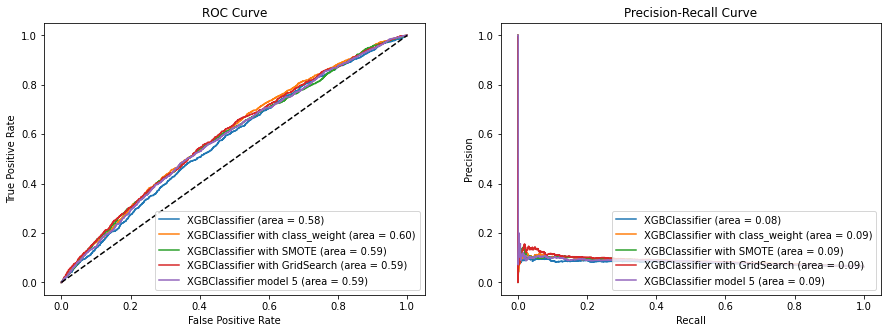

In [45]:
##plot roc-auc curve and precision-recall from xgb_clf, xgb_clf2, xgb_clf3, and best_xgb_clf IN A SINGLE 
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve, auc

##function to get tpr and fpr from model
##also get precision-recall curve in same function
def get_tpr_fpr(model, X_test, y_test):
    ##get probabilities
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    ##get fpr, tpr, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    ##get roc_auc
    roc_auc = auc(fpr, tpr)
    ##get precision and recall
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    ##get average precision
    average_precision = average_precision_score(y_test, y_pred_prob)
    return fpr, tpr, roc_auc, precision, recall, average_precision

##get tpr and fpr for xgb_clf
fpr, tpr, roc_auc, precision, recall, average_precision = get_tpr_fpr(xgb_clf, X_test_all, y_test)

##get tpr and fpr for xgb_clf2
fpr2, tpr2, roc_auc2, precision2, recall2, average_precision2 = get_tpr_fpr(xgb_clf2, X_test, y_test)

##get tpr and fpr for xgb_clf3
fpr3, tpr3, roc_auc3, precision3, recall3, average_precision3 = get_tpr_fpr(xgb_clf3, X_test, y_test)

##get tpr and fpr for best_xgb_clf
fpr4, tpr4, roc_auc4, precision4, recall4, average_precision4 = get_tpr_fpr(best_xgb_clf, X_test, y_test)

fpr5, tpr5, roc_auc5, precision5, recall5, average_precision5 = get_tpr_fpr(xgb_clf5, X_test, y_test)

###plot roc-curve and precision-recall curve side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

##plot roc-curve
ax1.plot(fpr, tpr, label=f'XGBClassifier (area = {roc_auc:.2f})')
ax1.plot(fpr2, tpr2, label=f'XGBClassifier with class_weight (area = {roc_auc2:.2f})')
ax1.plot(fpr3, tpr3, label=f'XGBClassifier with SMOTE (area = {roc_auc3:.2f})')
ax1.plot(fpr4, tpr4, label=f'XGBClassifier with GridSearch (area = {roc_auc4:.2f})')
ax1.plot(fpr5, tpr5, label=f'XGBClassifier model 5 (area = {roc_auc4:.2f})')
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend(loc="lower right")

##plot precision-recall curve
ax2.plot(recall, precision, label=f'XGBClassifier (area = {average_precision:.2f})')
ax2.plot(recall2, precision2, label=f'XGBClassifier with class_weight (area = {average_precision2:.2f})')
ax2.plot(recall3, precision3, label=f'XGBClassifier with SMOTE (area = {average_precision3:.2f})')
ax2.plot(recall4, precision4, label=f'XGBClassifier with GridSearch (area = {average_precision4:.2f})')
ax2.plot(recall5, precision5, label=f'XGBClassifier model 5 (area = {average_precision4:.2f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="lower right")

plt.show()


